In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd

from sklearn.linear_model import RidgeCV, LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, explained_variance_score


from general_code import *

In [3]:
#Read using function
y1, y2, y3, y4, X, realization = regressions.data_initialization(realiz=True)
X.head()

,enzyme_complex_concentration,enzyme_concentration,mu_mass,product_concentration,substrate_concentration,volume_fraction,sigma_mass_0.0,sigma_mass_0.825
0,-9.761988,-11.959213,12.1,-9.230543,-9.923690,0.2,1,0
1,-11.959213,-9.761988,12.1,-8.825078,-8.314252,0.2,1,0
2,-10.860600,-10.013302,31.9,-11.022305,-10.616837,0.2,0,1
3,-11.266065,-9.879771,12.1,-8.537396,-11.309985,0.4,1,0
4,-11.959213,-9.761988,12.1,-9.923690,-8.825078,0.2,1,0


In [4]:
Y = np.column_stack((y1, y1, y3, y4))

# Plots

Seems useless, nothing to see

# Data engineering

### Interactions w/o categories

# Regressions

## Ridge

### Interaction w/ categories
works better. Best performancefor ridge: _Degree 2 complete_

In [4]:
X = regressions.polynomial_data(X, 1, categories=True)

In [5]:
checkX = pd.DataFrame(X[:10,:])
checkX.head()

,0,1,2,3,4,5
0,-9.761988,-11.959213,12.1,-9.230543,-9.923690,0.2
1,-11.959213,-9.761988,12.1,-8.825078,-8.314252,0.2
2,-10.860600,-10.013302,31.9,-11.022305,-10.616837,0.2
3,-11.266065,-9.879771,12.1,-8.537396,-11.309985,0.4
4,-11.959213,-9.761988,12.1,-9.923690,-8.825078,0.2


### Train test splitting

In [36]:
X_train, X_test, y_train, y_test = train_test_split_realiz(X, Y, test_size=0.4)
print(X_train.shape, X_test.shape)

(91173, 41) (60783, 41)


### Fitting

In [37]:
ridge_reg = RidgeCV(alphas=np.logspace(-5,5,40), fit_intercept=False).fit(X_train, y_train)

print('Train R^2 score : ', ridge_reg.score(X_train, y_train), '\n',
     'Test R^2 score : ', ridge_reg.score(X_test, y_test))

Train R^2 score :  0.9772271563630285 
 Test R^2 score :  0.9772781415924489


In [38]:
y_pred_tr = ridge_reg.predict(X_train)
y_pred_te = ridge_reg.predict(X_test)

print('MSE on train : ', mean_squared_error(y_train, y_pred_tr), '\n',
     'MSE on test : ', mean_squared_error(y_test, y_pred_te))

MSE on train :  0.01996362339452579 
 MSE on test :  0.019946237140155434


In [11]:
print('alpha : ', ridge_reg.alpha_,'\n',
     'Coeff : ', ridge_reg.coef_)

alpha :  0.003665241237079626 
 Coeff :  [ 1.40099101e-02 -7.03980994e-02 -3.92428024e-02  5.02744229e-02
 -4.51612149e-02 -4.91458286e-02 -1.44835325e+00  1.31997844e-02
  8.10125627e-04  8.17234446e-04 -1.41009590e-02 -1.01627469e-04
  1.83142034e-04 -1.88953448e-04 -3.11658506e-03 -3.51916379e-02
 -3.52064617e-02  3.02798060e-03 -1.45337722e-04  4.10709773e-04
 -4.27640060e-04  6.83188972e-03 -2.11970139e-02 -1.80457878e-02
 -1.60080405e-03  4.07090122e-05 -2.27312648e-05  1.11969489e-01
  2.44314134e-02  2.58430079e-02 -3.49407711e-03 -1.82472524e-04
 -1.87094169e-02 -2.26375752e-02 -2.25236390e-02 -3.27078944e-03
 -1.64966589e-02 -2.59135698e-02 -2.32322581e-02 -1.23393055e+01
 -1.11338067e+00 -3.34972584e-01  1.31997844e-02  0.00000000e+00
  8.10125606e-04]


In [14]:
from sklearn import feature_selection

In [15]:
selection = feature_selection.RFE(ridge_reg).fit(X_train, y_train)

y_pred_tr = selection.predict(X_train)
y_pred_te = selection.predict(X_test)

print()
print('MSE on train : ', mean_squared_error(y_train, y_pred_tr), '\n',
     'MSE on test : ', mean_squared_error(y_test, y_pred_te))


NameError: name 'feature_selection' is not defined

## Support vector regression

### Train test splitting

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y1, random_state=0, test_size=0.4)
print(X_train.shape, X_test.shape)

(91173, 8) (60783, 8)


### Fitting

In [ ]:
svm_reg = SVR(kernel='poly', degree=2).fit(X_train,y_train)

print('Train R^2 score : ', svm_reg.score(X_train, y_train), '\n',
     'Test R^2 score : ', svm_reg.score(X_test, y_test))

In [ ]:
y_pred_tr = svm_reg.predict(X_train)
y_pred_te = svm_reg.predict(X_test)

print('MSE on train : ', mean_squared_error(y_train, y_pred_tr), '\n',
     'MSE on test : ', mean_squared_error(y_test, y_pred_te))

In [ ]:
np.random.seed

## Boosting

In [4]:
X = X.drop(columns=['sigma_mass_0.0', 'sigma_mass_0.825', 'enzyme_concentration'])
X = X.values

In [6]:
checkX = pd.DataFrame(X[:10,:])
checkX.head()

,0,1,2,3,4
0,-9.761988,12.1,-9.230543,-9.923690,0.2
1,-11.959213,12.1,-8.825078,-8.314252,0.2
2,-10.860600,31.9,-11.022305,-10.616837,0.2
3,-11.266065,12.1,-8.537396,-11.309985,0.4
4,-11.959213,12.1,-9.923690,-8.825078,0.2


### Train test splitting

In [7]:
X_train, X_test, y1_train, y1_test = train_test_split(X, y1, test_size=0.3)
print(X_train.shape, X_test.shape)

(106369, 5) (45587, 5)


### Fitting

In [40]:
import xgboost as xgb

In [41]:
param = {'max_depth': 10, 'eta': 1, 'silent': 1, 'subsample': 0.8}
# param['nthread'] = 4
param['reg_alpha'] = 0.7
# param['reg_lamda'] = 0.5
param['tree_method'] = 'gpu_hist'
# param['tree_method'] = 'auto'

In [42]:
dtrain1 = xgb.DMatrix(X_train, label=y1_train)
dtest = xgb.DMatrix(X_test)

xgbReg = xgb.train(params=param, dtrain=dtrain1)

y1_pred_tr = xgbReg.predict(dtrain1)
y1_pred_te = xgbReg.predict(dtest)

Train R^2 score :  0.9998409175157027 
 Test R^2 score :  0.9998346881622936
MSE on train :  0.00017711895543468076 
 MSE on test :  0.00018433214000005704


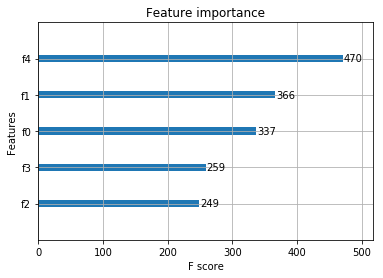

In [43]:
print('Train R^2 score : ', explained_variance_score(y1_train, y1_pred_tr), '\n',
     'Test R^2 score : ', explained_variance_score(y1_test, y1_pred_te))

print('MSE on train : ', mean_squared_error(y1_train, y1_pred_tr), '\n',
     'MSE on test : ', mean_squared_error(y1_test, y1_pred_te))

xgb.plot_importance(xgbReg)

In [44]:
from models import easyXGB

In [46]:
easyXGBReg = easyXGB()
easyXGBReg.set_params(tree_method = 'gpu_hist')
easyXGBReg.fit(X_train, y1_train)

In [47]:
y1_pred_tr = easyXGBReg.predict(X_train)
y1_pred_te = easyXGBReg.predict(X_test)

print('MSE on train : ', mean_squared_error(y1_train, y1_pred_tr), '\n',
     'MSE on test : ', mean_squared_error(y1_test, y1_pred_te))

MSE on train :  0.00017711893452052204 
 MSE on test :  0.00018433214000005704


In [48]:
print('MSE on train : ', easyXGBReg.score(X_train, y1_train), '\n',
     'MSE on test : ', easyXGBReg.score(X_test, y1_test))

MSE on train :  0.00017711893452052204 
 MSE on test :  0.00018433214000005704


# Tests

In [4]:
df = pd.DataFrame({'2' : 3*[2],
                  '3' : 3*[3],
                  'cat' : [1,0,1]},
                 index = list(range(3)))
df = william.cast_categories(df, 'cat')

In [29]:
M = np.array([[2,3,5]for _ in range(4)])
print(M)

[[2 3 5]
 [2 3 5]
 [2 3 5]
 [2 3 5]]


In [30]:
poly = PolynomialFeatures(2, interaction_only=False, include_bias=False)
M2 = poly.fit_transform(M)
print(M2)

[[ 2.  3.  5.  4.  6. 10.  9. 15. 25.]
 [ 2.  3.  5.  4.  6. 10.  9. 15. 25.]
 [ 2.  3.  5.  4.  6. 10.  9. 15. 25.]
 [ 2.  3.  5.  4.  6. 10.  9. 15. 25.]]


In [28]:
cond = True
[1 if x else 0 for x in df['a']==1]

[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]

In [32]:
cast_categories(df, 'a', cat_name='Number')

,b,Number 1,Number 2,Number 3
0,4,1,0,0
1,5,1,0,0
2,6,1,0,0
3,7,1,0,0
4,4,0,1,0
5,5,0,1,0
6,6,0,1,0
7,7,0,1,0
8,4,0,0,1
9,5,0,0,1
